In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime
import pickle
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

In [5]:
#load the predictions SR_ML/SMRAI2_current_predictions.nc
y_pred_current = xr.open_dataset('SMRAI2_current_predictions.nc')

Add more features for analysis

In [61]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    angle[angle < 0] += 360
    return angle

def clock_length(By, Bz):
    return np.sqrt(By**2 + Bz**2)

def CPCP(Vsw, B, theta):
    #from https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/96JA01742
    #and  https://www.sws.bom.gov.au/Category/Solar/Solar%20Conditions/Solar%20Wind%20Clock%20Angle/Solar%20Wind%20Clock%20Angle.php
    return 10e-4 * Vsw**2 + 11.7 * B * (np.sin(np.deg2rad(theta)/2))**3

y_pred_current['clock_angle'] = clock_angle(y_pred_current['BY_GSE'], y_pred_current['BZ_GSE'])
y_pred_current['clock_length'] = clock_length(y_pred_current['BY_GSE'], y_pred_current['BZ_GSE'])
y_pred_current['CPCP'] = CPCP(y_pred_current['flow_speed'], y_pred_current['clock_length'], y_pred_current['clock_angle'])
y_pred_current

<xarray.Dataset> Size: 215MB
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 45kB 2022-07-11T15:05:00 ... 2022-07-...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 0.1067 0.4071 0.7075 ... 23.54 23.84
Data variables:
    current         (dt, lat, lon) float64 107MB ...
    BY_GSE          (dt) float64 45kB 7.96 8.2 8.13 8.94 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 45kB -3.35 -2.99 -2.57 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 45kB 340.0 341.0 337.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 45kB ...
    tilt_angle      (dt) float64 45kB ...
    RMSE            (dt, lat, lon) float64 107MB ...
    clock_angle     (dt) float64 45kB 112.8 110.0 107.5 ... 265.2 246.6 240.2
    clock_length    (dt) float64 45kB 8.636 8.728 8.527 ... 8.801 10.14 9.474
    CPCP            (dt) float64 45kB 174.0 172.4 165.9 ... 247.2 285.5 300.3

In [14]:
y_pred_potential = xr.open_dataset('SMRAI2_potential_predictions.nc')
y_pred_potential

<xarray.Dataset> Size: 215MB
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 45kB 2022-07-11T15:05:00 ... 2022-07-...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 0.1067 0.4071 0.7075 ... 23.54 23.84
Data variables:
    potential       (dt, lat, lon) float64 107MB ...
    BY_GSE          (dt) float64 45kB ...
    BZ_GSE          (dt) float64 45kB ...
    flow_speed      (dt) float64 45kB ...
    proton_density  (dt) float64 45kB ...
    tilt_angle      (dt) float64 45kB ...
    RMSE            (dt, lat, lon) float64 107MB ...

In [36]:
#get maximum value of potential
y_pred_potential['potential'].min()

<xarray.DataArray 'potential' ()> Size: 8B
array(-57.78994217)

In [8]:
#common paramters for ax1 (radar plot)
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 30)

levels = np.linspace(-0.50, 0.50+0.01, 100)
shrink = 0.8
c_pad = 0.12
t_pad = 10

#current labels
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'

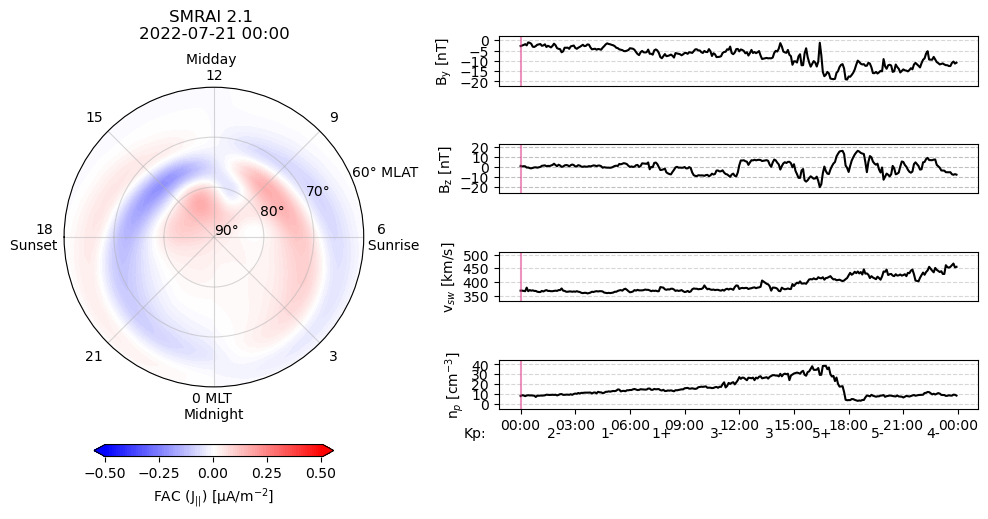

In [9]:
date = '2022-07-21'
time_plot = y_pred_current.sel(dt=date)['dt']
times = y_pred_current.sel(dt=date)['dt'].values
#remove the last time


for i, time in enumerate(times):

    # Create a figure and GridSpec with 5 rows and 2 columns
    fig = plt.figure(figsize=(10, 5.5))
    
    gs = GridSpec(5, 2, width_ratios=[5, 8])
    ax1 = fig.add_subplot(gs[:, 0], projection='polar') #make 1st column span all rows
    ax2_1 = fig.add_subplot(gs[0, 1])
    ax2_2 = fig.add_subplot(gs[1, 1], sharex=ax2_1)
    ax2_3 = fig.add_subplot(gs[2, 1], sharex=ax2_1)
    ax2_4 = fig.add_subplot(gs[3, 1], sharex=ax2_1)

    # ----------------- AX1 -----------------
    # ---------------------------------------
    #Title
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')
    ax1.set_title(f'SMRAI 2.1 \n{str_time}', pad=t_pad)

    #get data and plot
    pred_current = y_pred_current['current'].sel(dt=date).values[i]
    ax1_contour = ax1.contourf(theta_rad, r, pred_current, levels, cmap='bwr', extend='both')

    #decoration
    ax1.set_ylim([0, 30])
    ax1.set_yticks([0, 10, 20, 30])
    ax1.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax1.grid(True, linestyle='-', alpha=0.5)

    ax1.set_xlim([-np.pi, np.pi])
    ax1.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax1.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax1_contour, ax=ax1, label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')
    

    # ----------------- AX2.1 ---------------
    # ---------------------------------------
    #By = y_pred_current['BY_GSE'].sel(dt=date).values
    y_pred_current['BY_GSE'].sel(dt=date).plot(ax=ax2_1, color='k')
    ax2_1.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    By_lab = r'$\mathrm{B_y}$ [nT]'
    ax2_1.set_ylabel(By_lab)
    ax2_1.set_ylim([-22, 2])
    ax2_1.set_yticks([-20, -15, -10, -5, 0])
    ax2_1.yaxis.grid(True, linestyle='--', alpha=0.5)
    #set x axis to top of plot
    ax2_1.xaxis.set_ticks_position('top')
    ax2_1.set_xlabel(' ')


    # ----------------- AX2.2 ---------------
    # ---------------------------------------
    y_pred_current['BZ_GSE'].sel(dt=date).plot(ax=ax2_2, color='k')
    ax2_2.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    Bz_lab = r'$\mathrm{B_z}$ [nT]'
    ax2_2.set_ylabel(Bz_lab)
    ax2_2.set_ylim([-26, 23])
    ax2_2.set_yticks([-20, -10, 0, 10, 20])
    ax2_2.grid(True, linestyle='--', alpha=0.8)

    # ----------------- AX2.3 ---------------
    # ---------------------------------------
    y_pred_current['flow_speed'].sel(dt=date).plot(ax=ax2_3,color='k')
    ax2_3.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    v_sw_lab = r'v$_{sw}$ [km/s]'
    ax2_3.set_ylabel(f'{v_sw_lab}')
    ax2_3.set_ylim([330, 510])
    ax2_3.set_yticks([350, 400, 450, 500])
    ax2_3.grid(True, linestyle='--', alpha=0.5)


    # ----------------- AX2.4 ---------------
    # ---------------------------------------
    y_pred_current['proton_density'].sel(dt=date).plot(ax=ax2_4, color='k')
    ax2_4.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    n_p_lab = r'n$_p$ [cm$^{-3}$]'
    ax2_4.set_ylabel(f'{n_p_lab}')
    ax2_4.set_ylim([-5, 45])
    ax2_4.set_yticks([0, 10, 20, 30, 40])
    #ax2_4.grid(True, linestyle='--', alpha=0.5)
    ax2_4.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax2_4.set_xlabel(' ')
    
    #ax2_4.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    ax2_4.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))


    #add values to each of the x ticks on ax2_4
    kp = [1,2,3,4,5,6,7,8,9]

    #for i, val in enumerate(kp):
    #    plt.text(i, -7, f'{val}', color='k', ha='center', va='center', fontsize=10)

    annot_y = -0.5
    shift = 0.065
    ax2_4.annotate(f'Kp:', xy=(-0.05, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'2-', xy=(0.05+shift, annot_y), xycoords='axes fraction', ha='center', va='center') 
    ax2_4.annotate(f'1-', xy=(0.162+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'1+', xy=(0.275+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'3-', xy=(0.39+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'3', xy=(0.5+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'5+', xy=(0.61+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'5-', xy=(0.725+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_4.annotate(f'4-', xy=(0.84+shift, annot_y), xycoords='axes fraction', ha='center', va='center')

    
    #for i, val in enumerate(symh_hourly['Kp'].values):
    #plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

    #remove ticks
    for ax in [ax2_1, ax2_2, ax2_3]:
        ax.xaxis.set_visible(False)

    #remove top and right splines 
    #for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
    #    ax.spines['top'].set_visible(False)
    #    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/current_panel/2022-07-21/current_panel_{str_time}.png', dpi=300, bbox_inches='tight')
    #plt.close()

    if i in [0]:
        break


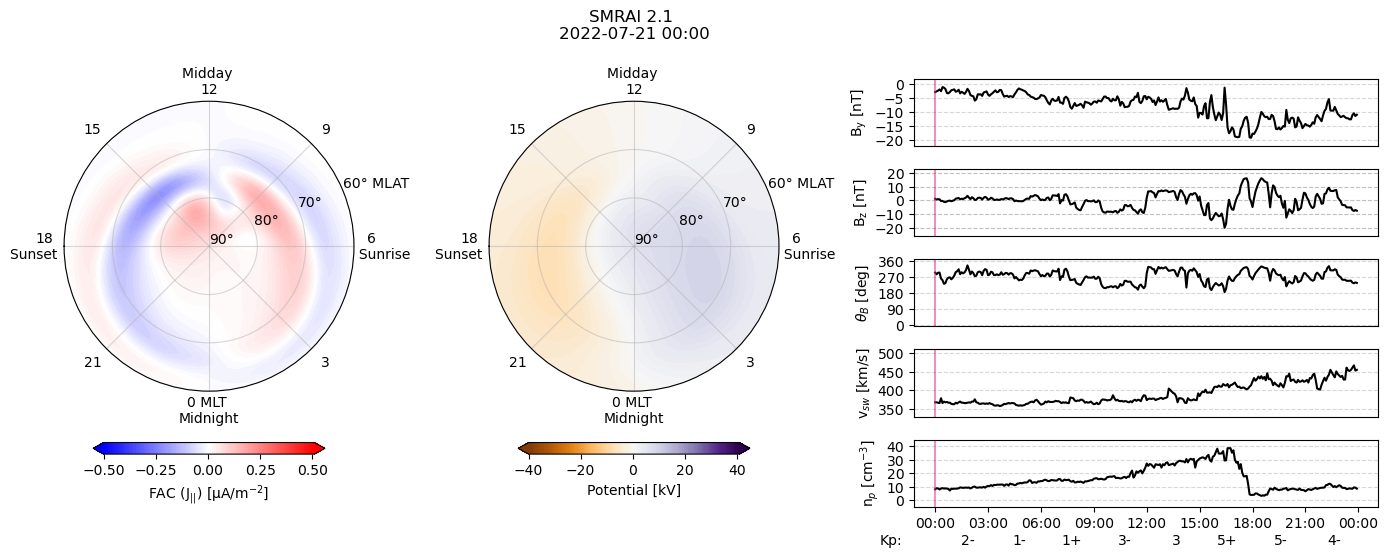

In [55]:
date = '2022-07-21'
time_plot = y_pred_current.sel(dt=date)['dt']
times = y_pred_current.sel(dt=date)['dt'].values
#remove the last time


for i, time in enumerate(times):

    # Create a figure and GridSpec with 5 rows and 2 columns
    fig = plt.figure(figsize=(14, 5.5))
    
    gs = GridSpec(5, 3, width_ratios=[5, 5, 8])
    ax1 = fig.add_subplot(gs[:, 0], projection='polar') #make 1st column span all rows
    ax2 = fig.add_subplot(gs[:, 1], projection='polar') #make 1st column span all rows
    ax2_1 = fig.add_subplot(gs[0, 2])
    ax2_2 = fig.add_subplot(gs[1, 2], sharex=ax2_1)
    ax2_3 = fig.add_subplot(gs[2, 2], sharex=ax2_1)
    ax2_4 = fig.add_subplot(gs[3, 2], sharex=ax2_1)
    ax2_5 = fig.add_subplot(gs[4, 2], sharex=ax2_1)

    # ----------------- AX1 -----------------
    # ---------------------------------------
    #get data and plot
    current_levels = np.linspace(-0.50, 0.50+0.01, 100)
    pred_current = y_pred_current['current'].sel(dt=date).values[i]
    ax1_contour = ax1.contourf(theta_rad, r, pred_current, current_levels, cmap='bwr', extend='both')

    #decoration
    ax1.set_ylim([0, 30])
    ax1.set_yticks([0, 10, 20, 30])
    ax1.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax1.grid(True, linestyle='-', alpha=0.5)

    ax1.set_xlim([-np.pi, np.pi])
    ax1.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax1.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax1_contour, ax=ax1, label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')


    # ----------------- AX2 -----------------
    # ---------------------------------------
    t_pad = 20

    #Title
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')
    ax2.set_title(f'SMRAI 2.1 \n{str_time}', pad=t_pad)

    #get data and plot
    pot_levels = np.linspace(-40, 41, 100)
    pred_potential = y_pred_potential['potential'].sel(dt=date).values[i]
    ax2_contour = ax2.contourf(theta_rad, r, -pred_potential, levels=pot_levels, cmap='PuOr', extend='both')

    #decoration
    ax2.set_ylim([0, 30])
    ax2.set_yticks([0, 10, 20, 30])
    ax2.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax2.grid(True, linestyle='-', alpha=0.5)

    ax2.set_xlim([-np.pi, np.pi])
    ax2.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax2.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax2_contour, ax=ax2, label=f'Potential [kV]', shrink=shrink, pad=c_pad, 
        ticks=[-40, -20, 0, 20, 40], orientation='horizontal')
    
    # ----------------- AX2.1 ---------------
    # ---------------------------------------
    #By = y_pred_current['BY_GSE'].sel(dt=date).values
    y_pred_current['BY_GSE'].sel(dt=date).plot(ax=ax2_1, color='k')
    ax2_1.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    By_lab = r'$\mathrm{B_y}$ [nT]'
    ax2_1.set_ylabel(By_lab)
    ax2_1.set_ylim([-22, 2])
    ax2_1.set_yticks([-20, -15, -10, -5, 0])
    ax2_1.yaxis.grid(True, linestyle='--', alpha=0.5)
    #set x axis to top of plot
    ax2_1.xaxis.set_ticks_position('top')
    ax2_1.set_xlabel(' ')


    # ----------------- AX2.2 ---------------
    # ---------------------------------------
    y_pred_current['BZ_GSE'].sel(dt=date).plot(ax=ax2_2, color='k')
    ax2_2.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    Bz_lab = r'$\mathrm{B_z}$ [nT]'
    ax2_2.set_ylabel(Bz_lab)
    ax2_2.set_ylim([-26, 23])
    ax2_2.set_yticks([-20, -10, 0, 10, 20])
    ax2_2.grid(True, linestyle='--', alpha=0.8)

    # ----------------- AX2.3 ---------------
    # ---------------------------------------
    y_pred_current['clock_angle'].sel(dt=date).plot(ax=ax2_3, color='k')
    ax2_3.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    clock_angle_lab = r'$\theta_{B}$ [deg]'
    ax2_3.set_ylabel(f'{clock_angle_lab}')
    ax2_3.set_ylim([-10, 370])
    ax2_3.set_yticks([0, 90, 180, 270, 360])
    ax2_3.grid(True, linestyle='--', alpha=0.5)
    ax2_3.set_xlabel(' ')

    # ----------------- AX2.4 ---------------
    # ---------------------------------------
    y_pred_current['flow_speed'].sel(dt=date).plot(ax=ax2_4,color='k')
    ax2_4.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    v_sw_lab = r'v$_{sw}$ [km/s]'
    ax2_4.set_ylabel(f'{v_sw_lab}')
    ax2_4.set_ylim([330, 510])
    ax2_4.set_yticks([350, 400, 450, 500])
    ax2_4.grid(True, linestyle='--', alpha=0.5)


    #for i, val in enumerate(symh_hourly['Kp'].values):
    #plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

    # ----------------- AX2.5 ---------------
    # ---------------------------------------
    y_pred_current['proton_density'].sel(dt=date).plot(ax=ax2_5, color='k')
    ax2_5.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    n_p_lab = r'n$_p$ [cm$^{-3}$]'
    ax2_5.set_ylabel(f'{n_p_lab}')
    ax2_5.set_ylim([-5, 45])
    ax2_5.set_yticks([0, 10, 20, 30, 40])
    #ax2_5.grid(True, linestyle='--', alpha=0.5)
    ax2_5.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax2_5.set_xlabel(' ')
    
    #ax2_5.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    ax2_5.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))


    #add values to each of the x ticks on ax2_5
    kp = [1,2,3,4,5,6,7,8,9]

    #for i, val in enumerate(kp):
    #    plt.text(i, -7, f'{val}', color='k', ha='center', va='center', fontsize=10)

    
    annot_y = -0.5
    shift = 0.065
    ax2_5.annotate(f'Kp:', xy=(-0.05, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'2-', xy=(0.05+shift, annot_y), xycoords='axes fraction', ha='center', va='center') 
    ax2_5.annotate(f'1-', xy=(0.162+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'1+', xy=(0.275+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'3-', xy=(0.39+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'3', xy=(0.5+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'5+', xy=(0.61+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'5-', xy=(0.725+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'4-', xy=(0.84+shift, annot_y), xycoords='axes fraction', ha='center', va='center')

    #remove ticks
    for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
        ax.xaxis.set_visible(False)

    #remove top and right splines 
    #for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
    #    ax.spines['top'].set_visible(False)
    #    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

    plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/current_potential_panel/2022-07-21/current_panel_{str_time}.png', dpi=300, bbox_inches='tight')
    #plt.close()

    if i in [0]:
        break
